# Logistic Regression

This notebook contains assessment of a logistic regressor. 

The data is obtained using 85 columns of `abnormal_writeout.data.csv`. 

Most of these 85 columns are highly colinear "confounder" variables against which we are comparing the `occ_total_sum` (total mutations of the gene across all cancers) and `oldest_phylostratum` (evolutionary age of the gene) variables. We apply PCA to the confounder variables and keep PCs up to 95% explained variance.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 85)

In [2]:
def fetch_data(drop_some=True):

    df = pd.read_csv("../data/abnormal_writeout.data.csv")

    if drop_some:
        # trascurare da ACC a UVM
        start_drop = df.columns.get_loc("ACC")
        end_drop = df.columns.get_loc("UVM")
        cols = np.arange(start_drop, end_drop + 1)
        df.drop(df.columns[cols], axis=1, inplace=True)

        # trascurare old_phylo_factor e la prima colonna
        df.drop("oldest_phylostratum_factor", axis=1, inplace=True)
        df.drop("Unnamed: 0", axis=1, inplace=True)

    return df


def separate_data(df):
    resp = df["response"]
    occ = df["occ_total_sum"]
    age = df["oldest_phylostratum"]
    conf = df.drop(labels=["response", "occ_total_sum", "oldest_phylostratum"], axis=1)
    return occ, age, conf, resp


def get_PCA(X, expl_var=0.95, plot=False):

    pca_test = PCA()
    pca_test.fit(X)
    cumsum = np.cumsum(pca_test.explained_variance_ratio_)
    d = np.argmax(cumsum >= expl_var) + 1

    # Apply PCA with d components
    pca_apply = PCA(n_components=d)
    X_PCA = pca_apply.fit_transform(X)

    print("Using {} principal components.".format(d))
    if plot == True:
        sns.heatmap(pd.DataFrame(X_PCA).corr())
        plt.show()

    return X_PCA

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Data
df = fetch_data()  # Get
df.dropna(inplace=True)  # Clean
X_occ, X_age, X_conf, Y = separate_data(df)  # Separate
X_conf_pca = get_PCA(X_conf)  # PCA

# All features, confounders with PCA
X = np.c_[X_occ, X_age,  X_conf_pca]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# model
logreg = LogisticRegression(max_iter=500)
logreg.fit(x_train, y_train)
print("Using a logistic regressor.")

Using 47 principal components.
Using a logistic regressor.


In [4]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)

# scores

cv_pred = cross_val_predict(logreg, x_train, y_train, cv=5)
pred = logreg.predict_log_proba(x_test)

# Confusion matrix
print("Confusion matrix:\n", confusion_matrix(y_train, cv_pred))

# Precision-Recall
print("\nPrecision:", precision_score(y_train, cv_pred))
print("Recall:", recall_score(y_train, cv_pred))
print("f1-score:", f1_score(y_train, cv_pred))

# AUC
pred = logreg.predict_log_proba(x_test)
print("\nAUC:", roc_auc_score(y_test, pred[:, 1]))

Confusion matrix:
 [[11110   135]
 [ 3116   175]]

Precision: 0.5645161290322581
Recall: 0.05317532664843513
f1-score: 0.09719522354901415

AUC: 0.6529248180794649


In [5]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

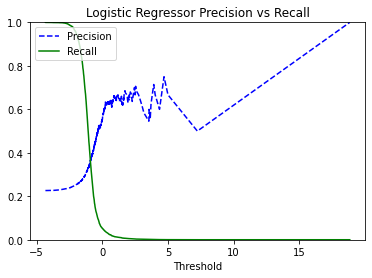

In [18]:
# Precision-Recall Curve

y_scores = cross_val_predict(logreg, x_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("Logistic Regressor Precision vs Recall")
plt.show()

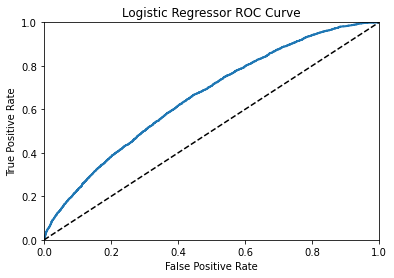

In [7]:
# ROC Curve

from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

plot_roc_curve(fpr, tpr) 
plt.title("Logistic Regressor ROC Curve")
plt.show()

In [8]:
# Save the model

from joblib import dump, load

dump(logreg, './saved_models/logreg.joblib') 

['./saved_models/logreg.joblib']

In [9]:
# model = load('filename.joblib')

## Cross-Validation

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(logreg, x_train, y_train, cv=3, scoring="roc_auc")

array([0.65904272, 0.66573044, 0.6471674 ])